In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
df = pd.read_csv('Preprocessed_Data.csv')
df.head()

,Annual Income (k$),Annual Income (k$) Spending Score (1-100),Genre,Income_per_Age,Spending Score (1-100)
0,-1.738999,-1.077128,1,-1.010344,-0.434801
1,-1.738999,-0.801479,1,-1.089296,1.195704
2,-1.700830,-1.291084,0,-0.999291,-1.715913
3,-1.700830,-0.794041,0,-1.108862,1.040418
4,-1.662660,-1.035562,0,-1.263499,-0.395980


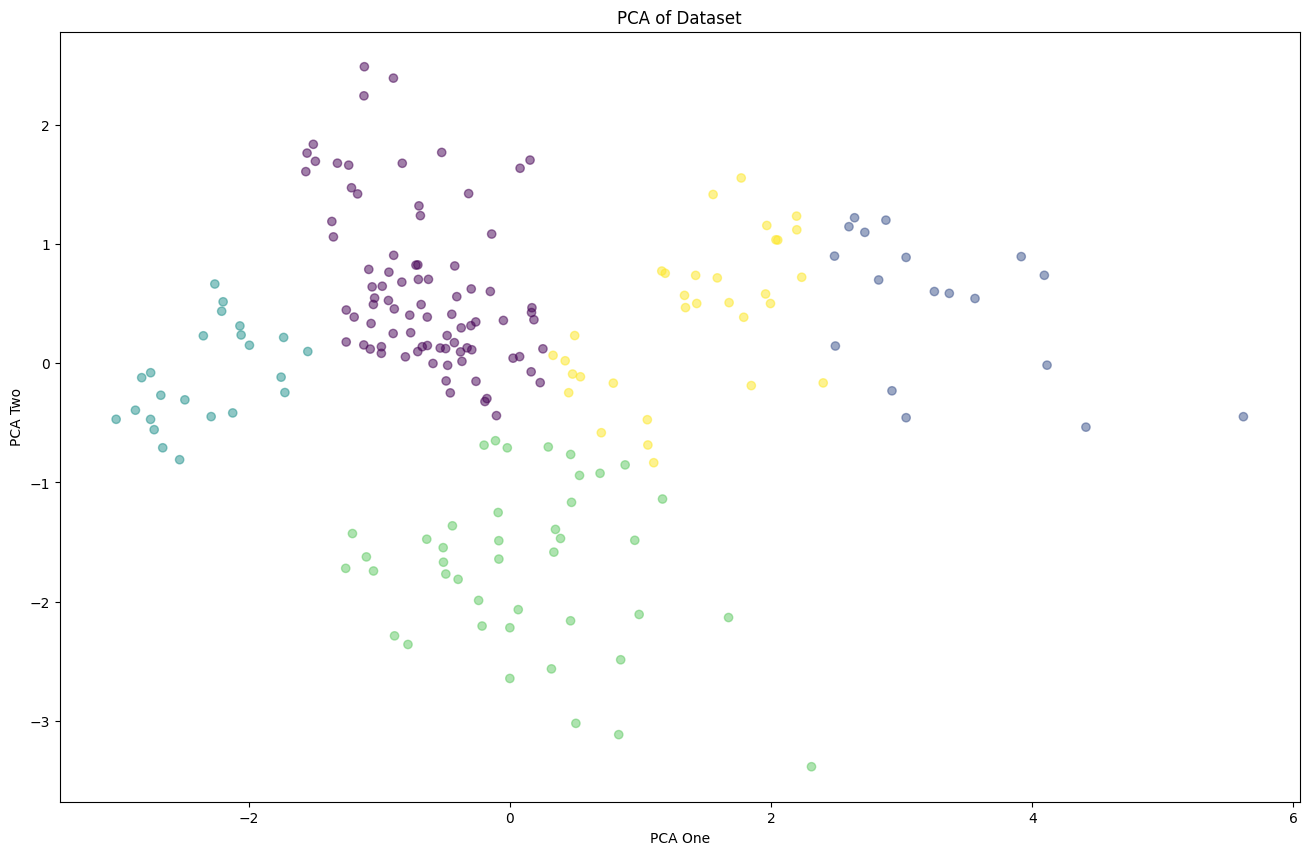

In [8]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

data_kmeans = df.copy() # already preprocessed
# apply clustering algorithm
Kmeans = KMeans(n_clusters=5, random_state=42)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_kmeans)
data_kmeans['pca-one'] = pca_result[:,0]
data_kmeans['pca-two'] = pca_result[:,1]
data_kmeans['cluster'] = Kmeans.fit_predict(data_kmeans)
plt.figure(figsize=(16,10))
plt.scatter(data_kmeans['pca-one'], data_kmeans['pca-two'], alpha=0.5, c=data_kmeans['cluster'], cmap='viridis')
plt.xlabel('PCA One')
plt.ylabel('PCA Two')
plt.title('PCA of Dataset')
plt.show()

/tmp/ipykernel_3109/3813220297.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


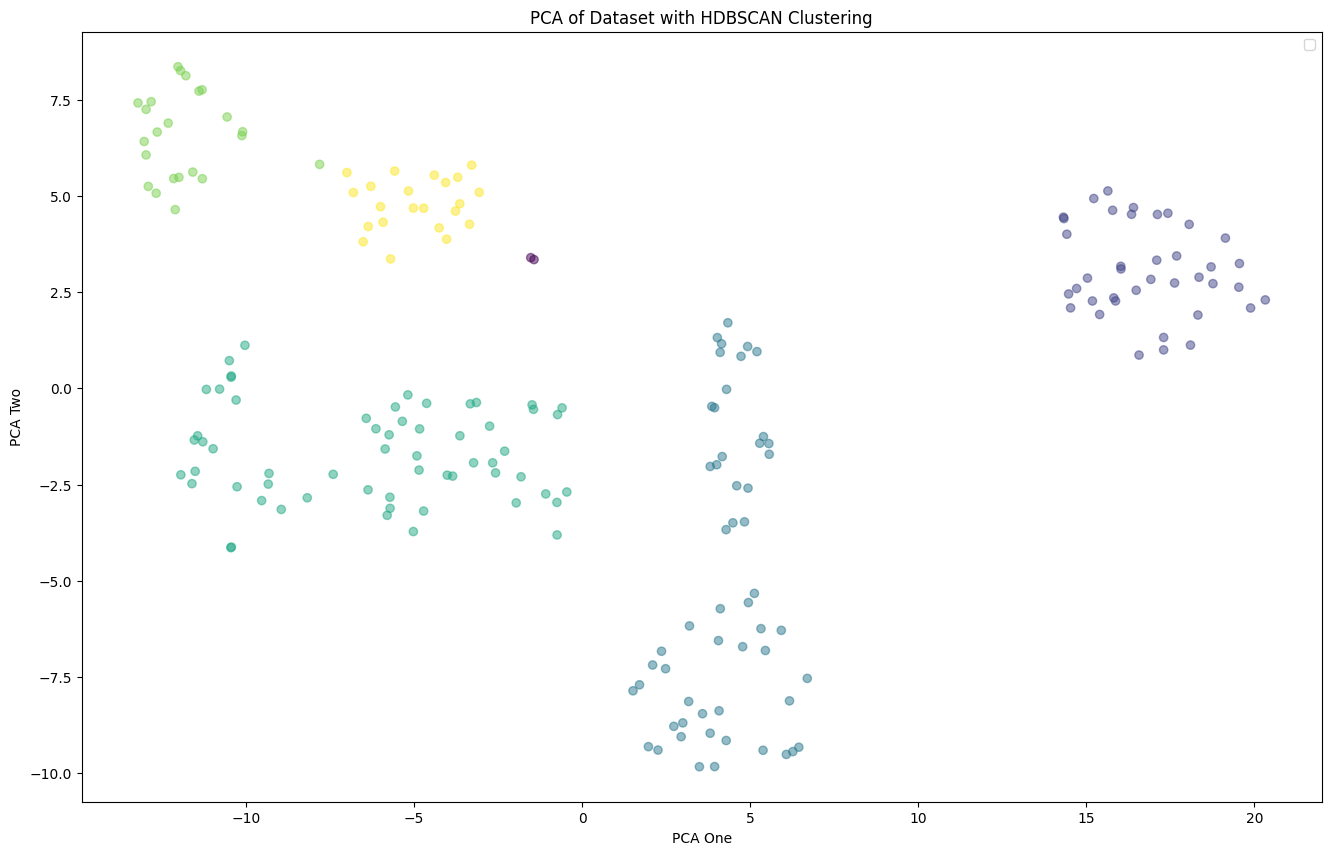

In [14]:
from sklearn.cluster import HDBSCAN
# import tSNE
from sklearn.manifold import TSNE
hdbscan_model = HDBSCAN(min_cluster_size=10)
data_hdbscan = df.copy() # already preprocessed
# apply clustering algorithm
tsne = TSNE(n_components=2, random_state=42)
tsne_result_hdbscan = tsne.fit_transform(data_hdbscan)
data_hdbscan['pca-one'] = tsne_result_hdbscan[:,0]
data_hdbscan['pca-two'] = tsne_result_hdbscan[:,1]
data_hdbscan['cluster'] = hdbscan_model.fit_predict(data_hdbscan)
plt.figure(figsize=(16,10))
plt.scatter(data_hdbscan['pca-one'], data_hdbscan['pca-two'], alpha=0.5, c=data_hdbscan['cluster'], cmap='viridis')
plt.xlabel('PCA One')
plt.ylabel('PCA Two')
plt.title('PCA of Dataset with HDBSCAN Clustering')
plt.legend()
plt.show()

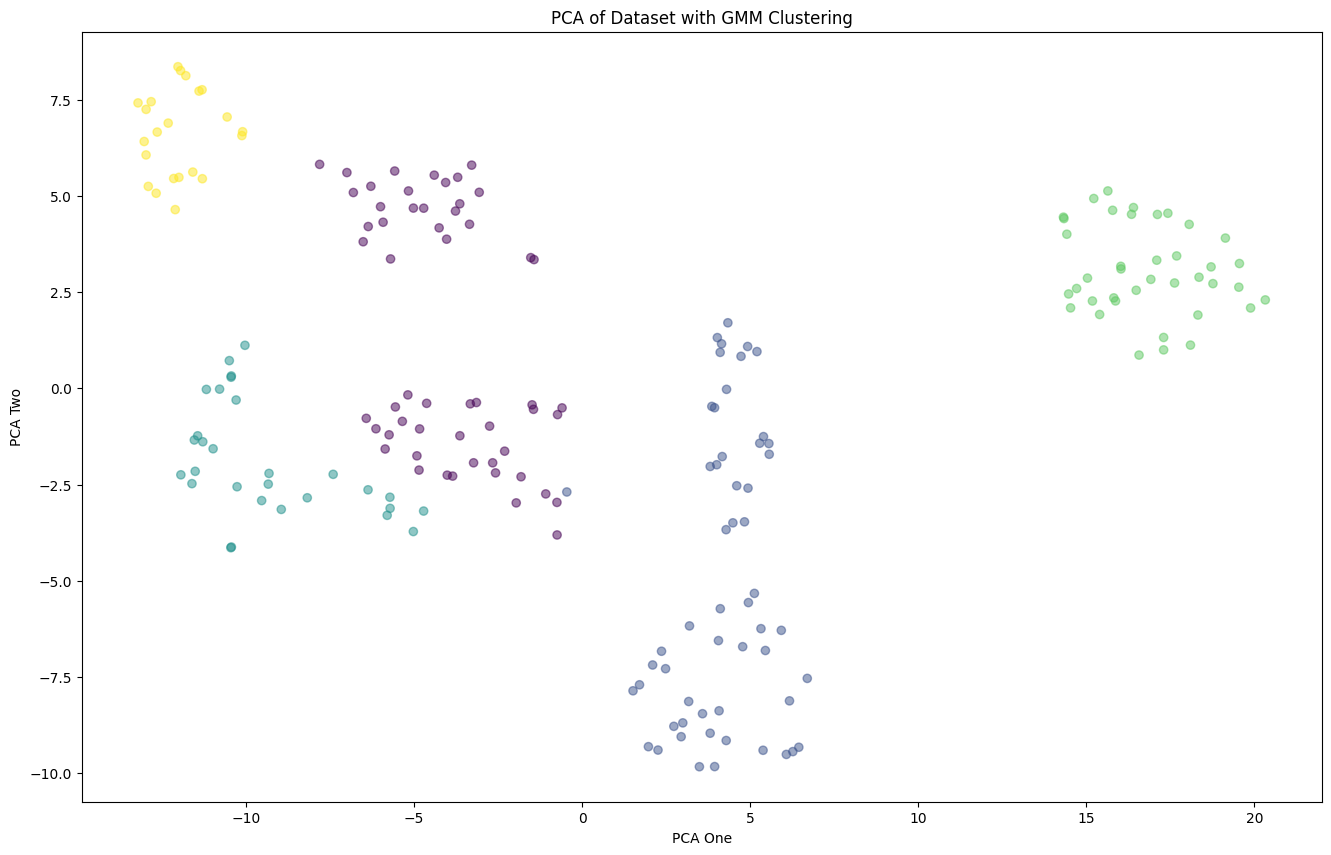

In [15]:
from sklearn.mixture import GaussianMixture
data_gmm = df.copy() # already preprocessed
# apply clustering algorithm
gmm = GaussianMixture(n_components=5, random_state=42)
tsne = TSNE(n_components=2, random_state=42)
tsne_result_gmm = tsne.fit_transform(data_gmm)
data_gmm['pca-one'] = tsne_result_gmm[:,0]
data_gmm['pca-two'] = tsne_result_gmm[:,1]
data_gmm['cluster'] = gmm.fit_predict(data_gmm)
plt.figure(figsize=(16,10))
plt.scatter(data_gmm['pca-one'], data_gmm['pca-two'], alpha=0.5, c=data_gmm['cluster'], cmap='viridis')
plt.xlabel('PCA One')
plt.ylabel('PCA Two')
plt.title('PCA of Dataset with GMM Clustering')
plt.show()

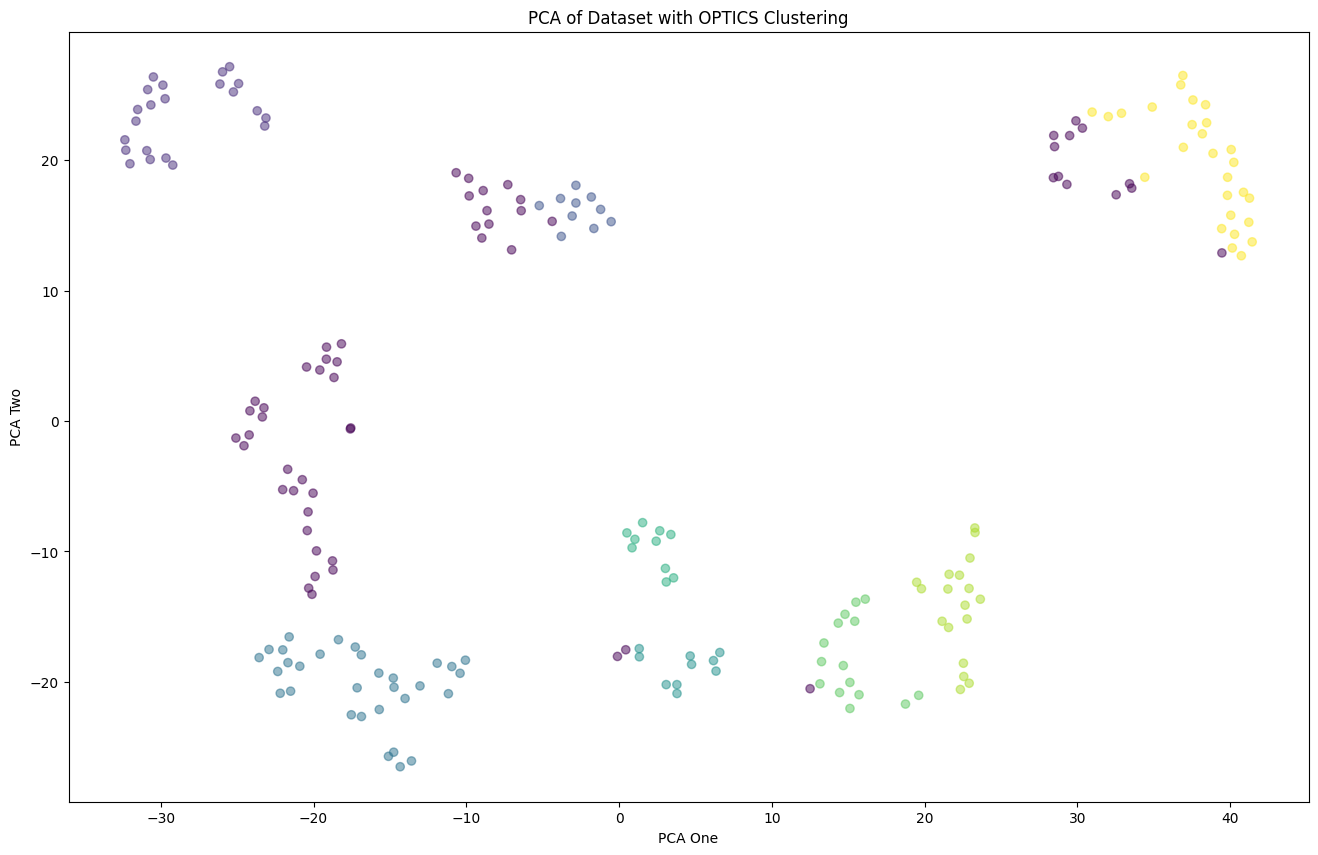

In [21]:
from sklearn.cluster import OPTICS
data_optics = df.copy() # already preprocessed
# apply clustering algorithm
optics = OPTICS(min_samples=10)
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
tsne_result_optics = tsne.fit_transform(data_optics)
data_optics['pca-one'] = tsne_result_optics[:,0]
data_optics['pca-two'] = tsne_result_optics[:,1]
data_optics['cluster'] = optics.fit_predict(data_optics)
plt.figure(figsize=(16,10))
plt.scatter(data_optics['pca-one'], data_optics['pca-two'], alpha=0.5, c=data_optics['cluster'], cmap='viridis')
plt.xlabel('PCA One')
plt.ylabel('PCA Two')
plt.title('PCA of Dataset with OPTICS Clustering')
plt.show()

In [22]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

def evaluate_clustering(predicted_labels, data):
    # Filter out noise points (labeled as -1) for silhouette score calculation
    if -1 in predicted_labels:
        non_noise_indices = predicted_labels != -1
        if np.sum(non_noise_indices) > 1: # Silhouette score requires at least 2 labels
            silhouette = silhouette_score(data[non_noise_indices], predicted_labels[non_noise_indices])
        else:
            silhouette = -1 # Not enough points to calculate
    else:
        silhouette = silhouette_score(data, predicted_labels)
    
    chs = calinski_harabasz_score(data, predicted_labels)
    return silhouette, chs

# Evaluate KMeans
kmeans_scores = evaluate_clustering(data_kmeans['cluster'].values, data_kmeans.drop(columns=['pca-one', 'pca-two', 'cluster']))

# Evaluate HDBSCAN
hdbscan_scores = evaluate_clustering(data_hdbscan['cluster'].values, data_hdbscan.drop(columns=['pca-one', 'pca-two', 'cluster']))

# Evaluate GMM
gmm_scores = evaluate_clustering(data_gmm['cluster'].values, data_gmm.drop(columns=['pca-one', 'pca-two', 'cluster']))

# Evaluate OPTICS
optics_scores = evaluate_clustering(data_optics['cluster'].values, data_optics.drop(columns=['pca-one', 'pca-two', 'cluster']))

print("KMeans Scores (Silhouette, Calinski-Harabasz):", kmeans_scores)
print("HDBSCAN Scores (Silhouette, Calinski-Harabasz):", hdbscan_scores)
print("GMM Scores (Silhouette, Calinski-Harabasz):", gmm_scores)
print("OPTICS Scores (Silhouette, Calinski-Harabasz):", optics_scores)

KMeans Scores (Silhouette, Calinski-Harabasz): (0.31574177233220324, 115.5273959335436)
HDBSCAN Scores (Silhouette, Calinski-Harabasz): (0.2799590317625415, 86.0942434544197)
GMM Scores (Silhouette, Calinski-Harabasz): (0.3256638629170615, 116.61476349569345)
OPTICS Scores (Silhouette, Calinski-Harabasz): (0.3691268811721017, 55.69947920757043)
